# <a style='color:blue'>Segmentez des clients d'un site e-commerce (Notebook 3: simulation)

- <a href="#C1">1: Préparation des données</a>
    - <a href="#C11">1.1 Imports</a>

- <a href="#C2">2: Simulation d'un contrat de maintenance</a>
    - <a href="#C21">2.1 Principes</a>
    - <a href="#C22">2.2 Etapes de la simulation</a>
    - <a href="#C23">2.3 Filtrage des données initiales</a>   
    - <a href="#C24">2.4 Entrainement du modèle sur les données initiales</a>
    - <a href="#C25">2.5 Ré-entrainement du modèle et recalcul de l'ARI</a>
    - <a href="#C26">2.6 Représentation de l'ARI en fonction de la date</a>
    - <a href="#C27">2.7 Détermination de la fréquence nécessaire de mise à jour</a>

# <a name="C1">Partie 1: Préparation des données</a>

# <a name="C11">1.1 Imports</a>

In [12]:
# librairies Pandas et Numpy
import pandas as pd
import numpy as np

# clustering
from sklearn.cluster import KMeans

# preprocessing
from sklearn import preprocessing

# visualisation
import matplotlib.pyplot as plt

# date and time
from datetime import datetime, timedelta

# import fichier CSV
data=pd.read_csv('data_after_feat_eng.csv')
data.set_index('customer_unique_id', inplace=True)
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])

# <a name="C2">Partie 2: Simulation d'un contrat de maintenance</a>

# <a name="C21">2.1 Principes</a>

- Evaluation de la stabilité du modèle dans le temps afin d’en assurer la maintenance

- Cette simulation nous permettra de déterminer la fréquence nécessaire de mise à jour du modèle de segmentation

# <a name="C22">2.2 Etapes de la simulation</a>

1 - Filtrage des données initiales => Toutes les commandes de l'années 2017

2 - Entrainement du modèle sur les données initiales => segmentation initial des clients (label_pred)

3 - Ré-entrainement du modèle sur les données initiales + chaque semaine => nouvelles segmentations des clients (label_true)

4 - Représentation de l'ARI en fonction de la date

5 - Détermination de la fréquence nécessaire de mise à jour (ARI <0.8)

# <a name="C23">2.3 Filtrage des données initiales</a>

In [2]:
#Filtrage des données initiales (on garde les commandes jusque fin 2017 seulement)
data_init=data[data['order_approved_at']<='2017-12-31 23:59:59']
data_init.shape

(42878, 5)

In [3]:
data_init.head()

,récence,fréquence,montant,review_score,order_approved_at
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,1,1,4.468434,3.0,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,3,1,3.798182,4.0,2017-10-12 20:49:17
0004aac84e0df4da2b147fca70cf8255,4,1,5.287711,5.0,2017-11-14 20:06:52
0005e1862207bf6ccc02e4228effd9a0,1,1,5.018074,4.0,2017-03-04 23:43:26
0006fdc98a402fceb4eb0ee528f6a8d4,2,1,3.401197,3.0,2017-07-18 09:30:22


In [4]:
# Liste initiale des clients (qui ont commandé en 2017)
list_init = data_init.index
list_init.shape

(42878,)

Nombre de clients uniques ayant commandé au 31/12/2017: 42878

# <a name="C24">2.4 Entrainement du modèle sur les données initiales</a>

Le score de récence calculé dans la phase de feature engineering se base sur la date de la dernière commande de l'ensemble du dataset.

Dans le cadre de cette simulation du contrat de maintenance, ce score devra être recalculé pour les données initiales, mais aussi pour chaque semaine de données ajoutées.

La fonction ci-dessous permet de recalculer le score de récence.

In [5]:
def update_recency (df):
    """
    Fonction qui recalcule le score de récense de 1 à 10 (récense=10 pour un achat très récent)
    :param df: DataFrame contenant les données à mettre à jour
    :return: DataFrame avec la colonne 'récence' mise à jour
    """
    date_max=df['order_approved_at'].max()
    date_min=df['order_approved_at'].min()
    
    # Conversion de 'order_approved_at' en Timedelta
    Nbdays=(date_max-df['order_approved_at']).dt.days
    Nbdays_max=(date_max-date_min).days

    # Calcul de la récence en jours
    Récence= Nbdays_max - Nbdays
    df['récence']=Récence
    
    # Calcul de la récence (de 1 à 10) en fonction des 10 quantiles de distributions
    df['récence'] = pd.qcut(df['order_approved_at'], q=10, labels=False) + 1
    
    return df

In [6]:
# Mise à jour de la récence sur les données initiales
data_init_updated=update_recency(data_init)
data_init_updated.head()

C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence']=Récence
C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence'] = pd.qcut(df['order_approved_at'], q=10, labels=False) + 1


,récence,fréquence,montant,review_score,order_approved_at
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,1,1,4.468434,3.0,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,7,1,3.798182,4.0,2017-10-12 20:49:17
0004aac84e0df4da2b147fca70cf8255,8,1,5.287711,5.0,2017-11-14 20:06:52
0005e1862207bf6ccc02e4228effd9a0,1,1,5.018074,4.0,2017-03-04 23:43:26
0006fdc98a402fceb4eb0ee528f6a8d4,4,1,3.401197,3.0,2017-07-18 09:30:22


In [7]:
# Filtrage et standardisation des données initiales
X=data_init_updated.loc[:,['récence','fréquence','montant','review_score']]
X=X.values 

std_scale = preprocessing.StandardScaler().fit(X)
X_init_norm= std_scale.transform(X)

In [8]:
# Entrainement du Keans pour K=5 sur les données initiales
cls_init=KMeans(n_clusters=5, init='k-means++', random_state=0)
cls_init.fit(X_init_norm)
labels_init = cls_init.labels_ 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# <a name="C25">2.5 Ré-entrainement du modèle et recalcule l'ARI</a>

- La fonction ci-dessous permet de mettre à jour la récence, ré-entrainer le modèle et  recalculer l'ARI à une date donnée

In [9]:
def retraining_ARI(df, date):
    """
    Fonction qui met à jour la récence, ré-entraine le modèle k-means et recalcule l'ARI à une date donnée
    :param df: DataFrame contenant les données à mettre à jour
    :param date: toutes les commandes validées avant 'date' sont sélectionnées
    :return: ARI calculé à la date passée en paramètre
    """
    # Filtrage dataframe df à une date donnée
    data_cut=df[df['order_approved_at']<=date]

    # Mise à jour de la récence
    data_cut_updated=update_recency(data_cut)

    # Filtrage et scaling
    X=data_cut_updated.loc[:,['récence','fréquence','montant','review_score']]
    X=X.values 
    std_scale = preprocessing.StandardScaler().fit(X)
    X_cut_norm= std_scale.transform(X)

    # Entrainement du Keans pour K=5 sur les données data_cut
    cls_cut=KMeans(n_clusters=5, init='k-means++', random_state=0)
    cls_cut.fit(X_cut_norm)
    labels_cut=cls_cut.labels_
   
    # Création d'un masque pour sélectionner uniquement les clients qui avaient commandé en 2017 
    mask= data_cut.index.isin(list_init)
    labels_cut_clean=labels_cut[mask]

    # Calcul de l'ARI entre la segmentation des données à date (entrée en paramètre) et la segmentation initiale (fin 2017)
    return metrics.adjusted_rand_score(labels_cut_clean, labels_init)

- Exécutons cette fonction pour chaque semaine de 2018

In [10]:
start_date = datetime(2018, 1, 1)
end_date = data['order_approved_at'].max()

ari_values = []
date_list = []

while start_date < end_date:
    date_list.append(start_date)
    ari_values.append(retraining_ARI(data, start_date))
    start_date += timedelta(weeks=1)

C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence']=Récence
C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence'] = pd.qcut(df['order_approved_at'], q=10, labels=False) + 1
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the v

C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence']=Récence
C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence'] = pd.qcut(df['order_approved_at'], q=10, labels=False) + 1
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the v

C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence']=Récence
C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence'] = pd.qcut(df['order_approved_at'], q=10, labels=False) + 1
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the v

C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence']=Récence
C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence'] = pd.qcut(df['order_approved_at'], q=10, labels=False) + 1
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the v

C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence']=Récence
C:\Users\Vincent-Formation\AppData\Local\Temp\ipykernel_7540\2674209280.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['récence'] = pd.qcut(df['order_approved_at'], q=10, labels=False) + 1
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the v

# <a name="C26">2.6 Représentation de l'ARI en fonction de la date</a>

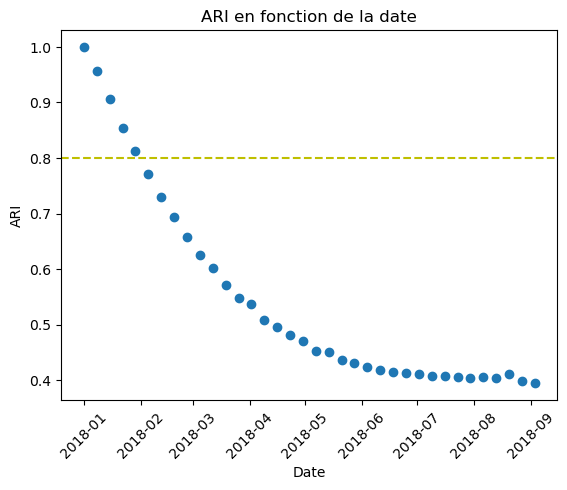

In [11]:
# Affichage de l'ARI chaque semaine à partir du 01/01/2018
plt.plot(date_list, ari_values, 'o')
plt.xlabel('Date')
plt.ylabel('ARI')
plt.title('ARI en fonction de la date')
plt.xticks(rotation=45)

# Ajout d'un seuil sur le graphique pour ARI=0.8
plt.axhline(y=0.8, color='y', linestyle='--')

plt.show()

# <a name="C27">2.7 Détermination de la fréquence nécessaire de mise à jour</a>

- L'ARI décroit et passe sous la valeur de 0.8 dès la 5ème semaine

- **Fréquence nécessaire de mise à jour du modèle de segmentation: toutes les 5 semaines**